In [1]:
data_path = '/home/mikehenry/small_tg_test/epoxpy-flow'

tau=1
tauP=10
num_c10=0
kT = 3.0
N=50000
use_curing_job_P=False
cooling_method = 'quench'
integrator='NPT'
pot='LangH'
activation_energy=3.0
density=1.0
quench_time=1e7
P = 10.0#[4.5, 6, 8]
stop_after_percents = [0.,50.0,70.,100.]
import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools

            
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

project = signac.get_project(data_path)
print("making df")
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
#print(statepoints)
df = pd.DataFrame(statepoints).T.join(df_index)
df = df.sort_values('T')
#df.head()
print("done")

making df
done


In [2]:
import numpy as np
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

def H0(x,x0,c):
        return 1/2*(x-x0)+((x-x0)**2/4+math.exp(c))**0.5
    
def hyper(x,x0,y0,a,b,c):
    #a=0.0
    return y0+a*(x-x0)+b*H0(x,x0,c)

def Pt(x,x0,c):
    return 0.5+ (x-x0)/(2*((x-x0)**2+4*math.exp(c))**0.5)

def slope_of_tangent(x,x0,a,b,c):
    #a=0.0
    return a+(0.5*b)+(b*(x-x0)/(2*(4*math.exp(c)+(x-x0)**2)**0.5))

def get_tangent(x,x0,y0,a,b,c):
    m=slope_of_tangent(x,x0,a,b,c)
    y=hyper(x,x0,y0,a,b,c)
    b=y-(m*x)
    return m,b

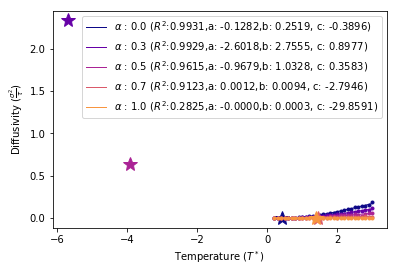

In [3]:
import matplotlib
%matplotlib inline
from piecewise.regressor import piecewise #https://www.datadoghq.com/blog/engineering/piecewise-regression/
from piecewise.plotter import plot_data_with_regression
import sys
sys.path.append("../")
from common import getDiffusivities, line_intersect, fit_Tg_to_DiBenedetto, DiBenedetto
PROP_NAME ='bparticles'
filter_saps=[0.0,30.,50.,70.]
filter_saps=[0.0,30.0,50.0,70.0,100.0]
colors = plt.cm.plasma(np.linspace(0,0.75,len(filter_saps)))
Tgs=[]
Tgs_tangent=[]
cure_percents = []
Cure_Ts=[]
markers=['+','.']
markersize=[10,10]
cooling_method='quench'
df_filtered=df[(df.quench_T<=3.0)&
               (df.quench_T>=0.2)&
               (df.CC_bond_angle!=109.5)&
               (df.cooling_method==cooling_method)]#(df.quench_T<=3.0)&(df.quench_T>=0.05)&
for i,sap in enumerate(filter_saps):
    cooling_colors = plt.cm.plasma(np.linspace(0,0.75,2))
    for j,(cooling_method,df_grp) in enumerate(df_filtered.groupby('cooling_method')):
        df_curing = df_grp[(df_grp.bond==False)&
                       (df_grp.calibrationT==305)&
                       (df_grp.cooling_method==cooling_method)&
                       (df_grp.stop_after_percent==sap)]
        cure_percent = df_curing.cure_percent.mean()
        cure_percents.append(cure_percent)
        Ts,Ds=getDiffusivities(project,df_curing,name=PROP_NAME)
        Cure_Ts.append(Ts)
        
        mul_fact=100
        Ds_scaled=Ds*mul_fact
        popt, pcov = curve_fit(hyper, 
                               Ts, 
                               Ds_scaled,
                              maxfev=200000)
        
        T0=popt[0]#x0
        D0=popt[1]/mul_fact#y0
        a=popt[2]/mul_fact
        b=popt[3]/mul_fact
        c=popt[4]
        Ps=Pt(Ts,T0,popt[4])
        #print('To',T0)
        #print('a',a,'b',b)
        #print('Ps',Ps[0],Ps[-1])
        xs = Ts
        yHYP = hyper(xs, *popt)
        residuals = Ds_scaled - yHYP
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((Ds_scaled-np.mean(Ds_scaled))**2)
        if ss_tot == 0:
            r_squared = 0
        else:
            r_squared = 1 - (ss_res / ss_tot)
        
        d=hyper(T0,*popt)
        plt.plot(T0,
                 d/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
                    
        plt.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0)
        
        m1,b1=get_tangent(Ts[0],*popt)
        m2,b2=get_tangent(Ts[-1],*popt)
        
        tgx,tgy=line_intersect(m1,b1,m2,b2)
        l1x=np.linspace(Ts[0],tgx+0.1)
        l1y=(m1*l1x)+b1
        #plt.plot(l1x,l1y/mul_fact,linewidth=1.0)
        l2x=np.linspace(tgx-0.1,Ts[-1])
        l2y=(m2*l2x)+b2
        #plt.plot(l2x,l2y/mul_fact,linewidth=1.0)

        Tgs_tangent.append(tgx)
        #print(yHYP/mul_fact)
        plt.plot(xs,
                 yHYP/mul_fact,
                 linewidth=1.0,
                color=colors[i],#cooling_colors[j],
                 label='$\\alpha$ : {:.1f} ($R^2$:{:.4f},a: {:.4f},b: {:.4f}, c: {:.4f})'.format(sap/100,
                                                                                              r_squared,
                                                                                              a,
                                                                                              b,
                                                                                              c))
        
        xvals = np.linspace(-3,4)
        yfits = hyper(xvals, *popt)
        if True:
            Tg=popt[0]
            Tgs.append(Tg)
        else:
            Tgs.append(tgx)
plt.legend(fontsize=10)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
Tgs = np.asarray(Tgs)
cure_percents = np.asarray(cure_percents)
data=[cure_percents,Tgs]
plt.xlabel('Temperature ($T^*$)')
plt.ylabel('Diffusivity ($\\frac{\\sigma^2}{\\tau}$)')
#savefig(plt,'hyperbola_fitting_unbounded',
#        'all_alphas.pdf')
#np.savetxt('hyperbola_fitting_unbounded/Tg_{}.txt'.format(cooling_method),np.transpose(data))

plt.show()

T1 1.5723442903435842e-13 lambda 0.5
300 K in T*: 9.827151814647401e-14


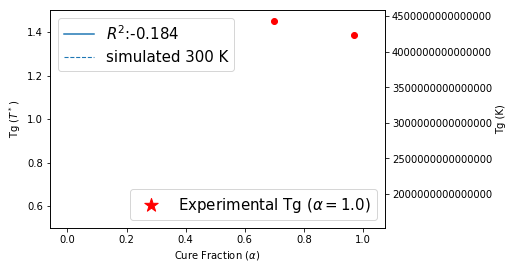

In [4]:
cure_percents = np.asarray(cure_percents)
fig, ax1 = plt.subplots()
ax2=ax1.twinx()
Tgs = np.asarray(Tgs)
Tgs_tangent = np.asarray(Tgs_tangent)
#print(Tgs)
Tg_data = np.asarray([cure_percents/100.,Tgs])
#np.savetxt('DGEBA_DDS__PES_w_angle_Tg.txt',Tg_data)
cure_percents_ss = cure_percents#[:-1]
Tgs_ss = Tgs#[:-1]
R2,fit_Tgs,T1,inter_parm,T0 = fit_Tg_to_DiBenedetto(cure_percents_ss/100.,
                                                 Tgs_ss,
                                                 T1=None,
                                                 T0=None)
print('T1',T1,'lambda',inter_parm)
alphas = np.linspace(0,1)
fit_ydata = DiBenedetto(alphas,T1,T0=T0,inter_param=inter_parm)
ax1.plot(alphas,fit_ydata,label='$R^2$:{}'.format(round(R2,3)))
ax1.scatter(cure_percents/100.,
            Tgs,
            color='r')#colors[i])

Tg_sim = T1#0.851796418313
Tg_exp = 480
roomT_exp = 300
Tex_toTsim = Tg_exp/Tg_sim
roomT_sim =  Tg_sim*roomT_exp/Tg_exp
Tg0_exp = Tg_exp*T0/Tg_sim
print('300 K in T*:',roomT_sim)
ax2.scatter(1.00,Tg_exp,marker='*',color='r',s=200,label='Experimental Tg ($\\alpha=1.0$)')
ax2.set_ylabel('Tg (K)')

sim_low_lim = 0.5
ex_low_lim = sim_low_lim*Tex_toTsim
sim_up_lim = 1.5
ex_up_lim = sim_up_lim*Tex_toTsim
ax2.set_ylim(ex_low_lim,ex_up_lim)
ax1.set_ylim(sim_low_lim,sim_up_lim)
show_roomT=True
if show_roomT:
    ax1.axhline(y=roomT_sim,linewidth=1.1,linestyle='--',label='simulated 300 K')
ax1.set_xlabel('Cure Fraction ($\\alpha$)')
ax1.set_ylabel('Tg ($T^*$)')
ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='lower right')
plt.ticklabel_format(axis='y',style='plain')
#savefig(plt,'hyperbola_fitting_unbounded','dibeneditto.pdf')

To -3.9572966833390053
a -1.0267116852558464 b 1.0916845544946987
Ps 0.9355769088807951 0.9738472015737121


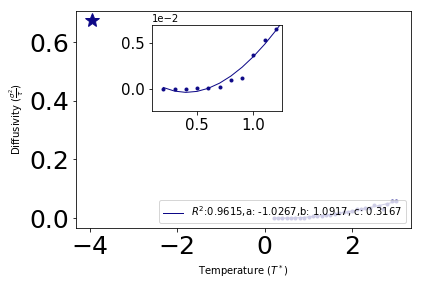

In [5]:
import matplotlib
from common import *
%matplotlib inline
from piecewise.regressor import piecewise #https://www.datadoghq.com/blog/engineering/piecewise-regression/
from piecewise.plotter import plot_data_with_regression

fig = plt.figure()
ax1 = fig.add_subplot(111)

left, bottom, width, height = [0.3, 0.53, 0.30, 0.30]
ax2 = fig.add_axes([left, bottom, width, height])
PROP_NAME ='bparticles'
filter_saps=[50.]#,100.]#,100.]#[0.0,50.0,100.0]#,30,50,70]#,90]
colors = plt.cm.plasma(np.linspace(0,0.75,len(filter_saps)))
Tgs=[]
Tgs_tangent=[]
cure_percents = []
Cure_Ts=[]
markers=['+','.']
markersize=[10,10]
cooling_method='quench'
df_filtered=df[(df.quench_T<=3.0)&
               (df.quench_T>=0.2)&
               (df.CC_bond_angle!=109.5)&
               (df.cooling_method==cooling_method)]#(df.quench_T<=3.0)&(df.quench_T>=0.05)&
for i,sap in enumerate(filter_saps):
    cooling_colors = plt.cm.plasma(np.linspace(0,0.75,2))
    for j,(cooling_method,df_grp) in enumerate(df_filtered.groupby('cooling_method')):
        df_curing = df_grp[(df_grp.bond==False)&
                       (df_grp.calibrationT==305)&
                       (df_grp.cooling_method==cooling_method)&
                       (df_grp.stop_after_percent==sap)]
        cure_percent = df_curing.cure_percent.mean()
        cure_percents.append(cure_percent)
        Ts,Ds=getDiffusivities(project,df_curing,name=PROP_NAME)
        Cure_Ts.append(Ts)
        
        mul_fact=10000
        Ds_scaled=Ds*mul_fact
        popt, pcov = curve_fit(hyper, 
                               Ts, 
                               Ds_scaled,
                              maxfev=200000)
        
        T0=popt[0]#x0
        D0=popt[1]/mul_fact#y0
        a=popt[2]/mul_fact
        b=popt[3]/mul_fact
        c=popt[4]
        Ps=Pt(Ts,T0,popt[4])
        print('To',T0)
        print('a',a,'b',b)
        print('Ps',Ps[0],Ps[-1])
        xs = Ts#np.linspace(0.1,4)
        yHYP = hyper(xs, *popt)
        residuals = Ds_scaled - yHYP
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((Ds_scaled-np.mean(Ds_scaled))**2)
        if ss_tot == 0:
            r_squared = 0
        else:
            r_squared = 1 - (ss_res / ss_tot)
        
        d=hyper(T0,*popt)
        ax1.plot(T0,
                 d/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
        ax2.plot(T0,
                 d/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
                    
        ax1.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0)
        ax2.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0)
        
        m1,b1=get_tangent(Ts[0],*popt)
        m2,b2=get_tangent(Ts[-1],*popt)
        
        tgx,tgy=line_intersect(m1,b1,m2,b2)
        l1x=np.linspace(Ts[0],tgx+0.1)
        l1y=(m1*l1x)+b1
        #plt.plot(l1x,l1y/mul_fact,linewidth=1.0)
        l2x=np.linspace(tgx-0.1,Ts[-1])
        l2y=(m2*l2x)+b2
        #plt.plot(l2x,l2y/mul_fact,linewidth=1.0)

        Tgs_tangent.append(tgx)
        #print(yHYP/mul_fact)
        ax1.plot(xs,
                 yHYP/mul_fact,
                 linewidth=1.0,
                color=colors[i],#cooling_colors[j],
                 label='$R^2$:{:.4f},a: {:.4f},b: {:.4f}, c: {:.4f}'.format(r_squared,
                                                                            a,
                                                                            b,
                                                                            c))
        ax2.plot(xs,
                 yHYP/mul_fact,
                 linewidth=1.0,
                 color=colors[i],#cooling_colors[j],
                 label='$R^2$:{:.4f},a: {:.4f},b: {:.4f}, c: {:.4f}'.format(r_squared,
                                                                            a,
                                                                            b,
                                                                            c))
        
        xvals = np.linspace(-3,4)
        yfits = hyper(xvals, *popt)
        if True:
            Tg=popt[0]
            Tgs.append(Tg)
        else:
            Tgs.append(tgx)
ax1.legend(fontsize=10,loc='lower right')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2),size=1)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-2,2),)
ax2.tick_params(axis = 'both', which = 'major',labelsize=15)
ax1.tick_params(axis = 'both', which = 'major',labelsize=25)
Tgs = np.asarray(Tgs)
cure_percents = np.asarray(cure_percents)
data=[cure_percents,Tgs]
ax2.set_xlim(0.1,1.25)
ax2.set_ylim(-2.5e-3,7e-3)
ax1.set_xlabel('Temperature ($T^*$)')
ax1.set_ylabel('Diffusivity ($\\frac{\\sigma^2}{\\tau}$)')
#savefig(plt,'hyperbola_fitting_unbounded',
#        '50percent.pdf')

plt.show()